In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random
import math

In [2]:
# Constants:
COOP = 1
DEF = 0
T = 5
R = 3 
P = 1 
S = 0 

def distributePrize(me, them):
    if me == them == COOP:
        return R
    if (me == COOP) and (them == DEF):
        return S
    if (me == DEF) and (them == COOP):
        return T
    return P

## Rules:
### Cooperate Unconditionally (Cu)
Always cooperate
### Defect Unconditionally (Du)
Always defect
### Rand
Random choice
### Cooperate probability (Cp)
Cooperate a percentage of the time
### Tit for tat (TFT)
Starts with cooperate, then copies other players previous move
### Suspicious TFT (STFT)
TFT but starts with defect
### Gradual TFT (GrdTFT)
TFT, but every time they defect you defect, and if they defect multiple times you follow with a chain of defections equal to the number of times they defected. After this chain is finished, cooperate twice in a row as an apology

In [3]:
class Agent:
    def __init__(self, short=True):
        self.score = 0
        self.past = []
        self.againstAgentScore = {}
        self.againstAgentWins = {}
        if short:
            self.short()
    
    def reset(self):
        self.score = 0
    
    def playMove(self, them, rn):
        return self.rule(them, rn)

    def addScore(self, result):
        self.score += result

    def getScore(self):
        return self.score

    def finishGame(self, score, outcome, enemy):
        # Outcome == 1 if won, 0 if lost
        self.againstAgentScore[enemy] = self.againstAgentScore.get(enemy, 0) + score
        self.againstAgentWins[enemy] = self.againstAgentWins.get(enemy, 0) + outcome
        self.reset()

    def __repr__(self):
        return self.name

class Cu(Agent):
    name = "Cooperate unconditionally"
    def rule(self, them, rn):
        return COOP
    def short(self):
        self.name = 'cu'

class Du(Agent):
    name = "Defect unconditionally"
    def rule(self, them, rn):
        return DEF
    def short(self):
        self.name = 'du'

class Rand(Agent):
    name = "Random"
    def rule(self, them, rn):
        return random.randint(0,2)
    def short(self):
        self.name = 'rand'

class Cp(Agent):
    name = "Cooperate probabilistically"
    def rule(self, them, rn):
        if random.rand() >= .75:
            return COOP
        return DEF
    def short(self):
        self.name = 'cp'

class TFT(Agent):
    name = "Tit for Tat"
    def rule(self, them, rn):
        if rn == 0: return COOP
        else: return them[-1]
    def short(self):
        self.name = 'tft'

class STFT(Agent):
    name = "Suspicious Tit for Tat"
    def rule(self, them, rn):
        if rn == 0: return DEF
        return them[-1]
    def short(self):
        self.name = 'stft'

AGENTTYPES = {'du':Du, 'cu':Cu, 'rand':Rand, 'cp':Cp, 'tft':TFT, 'stft':STFT}
SHORTTOLONG = {'du':'Unconditionally Defect', 'cu':'Unconditionally Cooperate', 
               'rand':'Random', 'cp':'Cooperate Probabilistically', 'tft':'Tit For Tat', 'stft':'Suspicious Tit For Tat'}

In [4]:
class AgentBuilder:
    def xOfEach(self, *args):
        agents = ''
        filename = 'Plots/game'
        for arg in args:
            name = f"{arg[0].lower().strip()} "
            agents += name*arg[1]
            filename += f'{arg[1]}{arg[0].lower().strip()}'
        filename += ".png"
        return agents, filename

    def rand(self, num):
        names = np.array(list(AGENTTYPES.keys()))
        agents = random.choice(names, size=num)
        unique, counts = np.unique(agents, return_counts=True)
        ags = dict(zip(unique, counts))
        filename = 'Plots/game'
        agentStr = ''
        for name, count in ags.items():
            agentStr += (f'{name} '*count)
            filename += f'{count}{name}'
        filename += '.png'
        return agentStr, filename

In [5]:
class Arbiter:
    # Manages games between two agents
    def __init__(self, rounds):
        self.rounds = rounds
        self.overallscores = {}
        self.wins = {}
        self.agents = {}

    def playNMatches(self, a1, a2, N):
        self.agents.update({a1:a1})
        self.agents.update({a2:a2})
        for _ in range(N):
            self.playMatch(a1, a2)
    
    def playMatch(self, a1, a2):
        a1past = []
        a2past = []

        for n in range(self.rounds):
            a1past, a2past = self.playOneGame(a1, a1past, a2, a2past, n)

        a1score = a1.getScore()
        a2score = a2.getScore()
        self.overallscores[a1] = self.overallscores.get(a1, 0) + a1score
        self.overallscores[a2] = self.overallscores.get(a2, 0) + a2score

        a1win, a2win = 0, 0
        if a1score > a2score: a1win = 1
        else: a2win = 1
        self.wins[a1] = self.wins.get(a1, 0) + a1win
        self.wins[a2] = self.wins.get(a2, 0) + a2win
        a1.finishGame(a1score, a1win, a2)
        a2.finishGame(a2score, a2win, a1)
        
    def playOneGame(self, a1, a1past, a2, a2past, roundnum):
        m1 = a1.rule(a2past, roundnum)
        m2 = a2.rule(a1past, roundnum)
        a1past.append(m1)
        a2past.append(m2)
        a1.addScore(distributePrize(m1, m2))
        a2.addScore(distributePrize(m2, m1))
        return a1past, a2past

    def displayScores(self):
        print("Overall Scores: ",self.overallscores)
        for agent in self.agents:
            print(f"Agent {agent} score {self.overallscores[agent]}, broken up as: {agent.againstAgentScore}")
        print("Wins:", self.wins)

    def roundRobinScheduler(self, players):
        if players % 2 == 1: players += 1
        half = players//2
        days = []
        for x in range(players-1, -1, -1):
            first = [0]*half
            second = []
            count = 0
            for n in range(x+half,x+half-players,-1):
                player = n%players
                if player == 0:
                    continue
                elif count < half-1:
                    first[half-count-1] = player
                    count += 1
                else:
                    second.append(player)
            days.append([first,second])
        days.pop(half)
        return days

    def scheduleGames(self, days):
        games = []
        matches = len(days[0][0])
        for day in days:
            for match in range(matches):
                games.append([day[0][match],day[1][match]])
        return games
            
    def parseAgentString(self, string):
        names = string.lower().strip().split(' ')
        agents = []
        for name in names:
            agents.append(AGENTTYPES[name]())
        return agents

    def playTournament(self, agentStr, N, filename, text=False):
        agents = self.parseAgentString(agentStr)
        roundRobinGames = self.scheduleGames(self.roundRobinScheduler(len(agents)))
        for game in roundRobinGames:
            self.playNMatches(agents[game[0]], agents[game[1]], N)
        self.graphScores(agents, filename, text)
        return agents

    def graphScores(self, agents, filename, labels=True):
        grid = np.zeros((len(agents) + 1, len(agents)))
        scores = np.zeros(len(agents))
        for idx, agent in enumerate(agents):
            print(f"Agent {agent} is index {idx}")
            for idx2 in range(len(agents)):
                if idx==idx2: continue
                grid[idx2, idx] = agent.againstAgentScore[agents[idx2]]
            scores[idx] = (self.overallscores[agent])
        fig, ax = plt.subplots(figsize=(13,13))
        plt.imshow(grid,cmap='YlOrRd')
        plt.colorbar()
        plt.xlabel('Agent', fontsize=20)
        plt.ylabel('Opponent', fontsize=20)
        if labels:
            for i in range(grid.shape[0]-1):
                for j in range(grid.shape[1]):
                    if i == j:
                        text = ax.text(j, i, f"Against\nItself", ha="center", va="center", color="k", rotation=-20)ax.text(j, i, f"Against\nItself", ha="center", va="center", color="k", rotation=-20)
                    else:
                        text = ax.text(j, i, f"{agents[j].name} vs {agents[i].name}\n{grid[i, j]/10000}", ha="center", va="center", color="k", rotation=-20)
            for i in range(grid.shape[1]):
                text = ax.text(i, grid.shape[1], f"{agents[i].name}\n{scores[i]/10000}", ha="center", va="center", color="k", rotation=-20)
        title = ''#'Graph read as: X axis is the agent in question, and the y axis is who they played against. \nThe higher the number, the more they scored against that opponent.\nThe last row is the agent\'s total score.\n'
        agnames = []
        for agent in agents: agnames.append(agent.name)
        unique, counts = np.unique(agnames, return_counts=True)
        ags = dict(zip(unique, counts))
        a = 0
        for name, count in ags.items():
            a += 1
            if a%3 == 0: title +='\n'
            title += f"{count} {SHORTTOLONG[name]}({name}), "
        plt.title(title[:-2], wrap=True, fontsize=15)
        plt.savefig(filename)
        print(title)

cu du rand rand rand stft stft tft tft tft 
Agent cp is index 0
Agent cp is index 1
Agent cu is index 2
Agent cu is index 3
Agent du is index 4
Agent rand is index 5
Agent rand is index 6
Agent stft is index 7
Agent tft is index 8
Agent tft is index 9
2 Cooperate Probabilistically(cp), 2 Unconditionally Cooperate(cu), 
1 Unconditionally Defect(du), 2 Random(rand), 1 Suspicious Tit For Tat(stft), 
2 Tit For Tat(tft), 


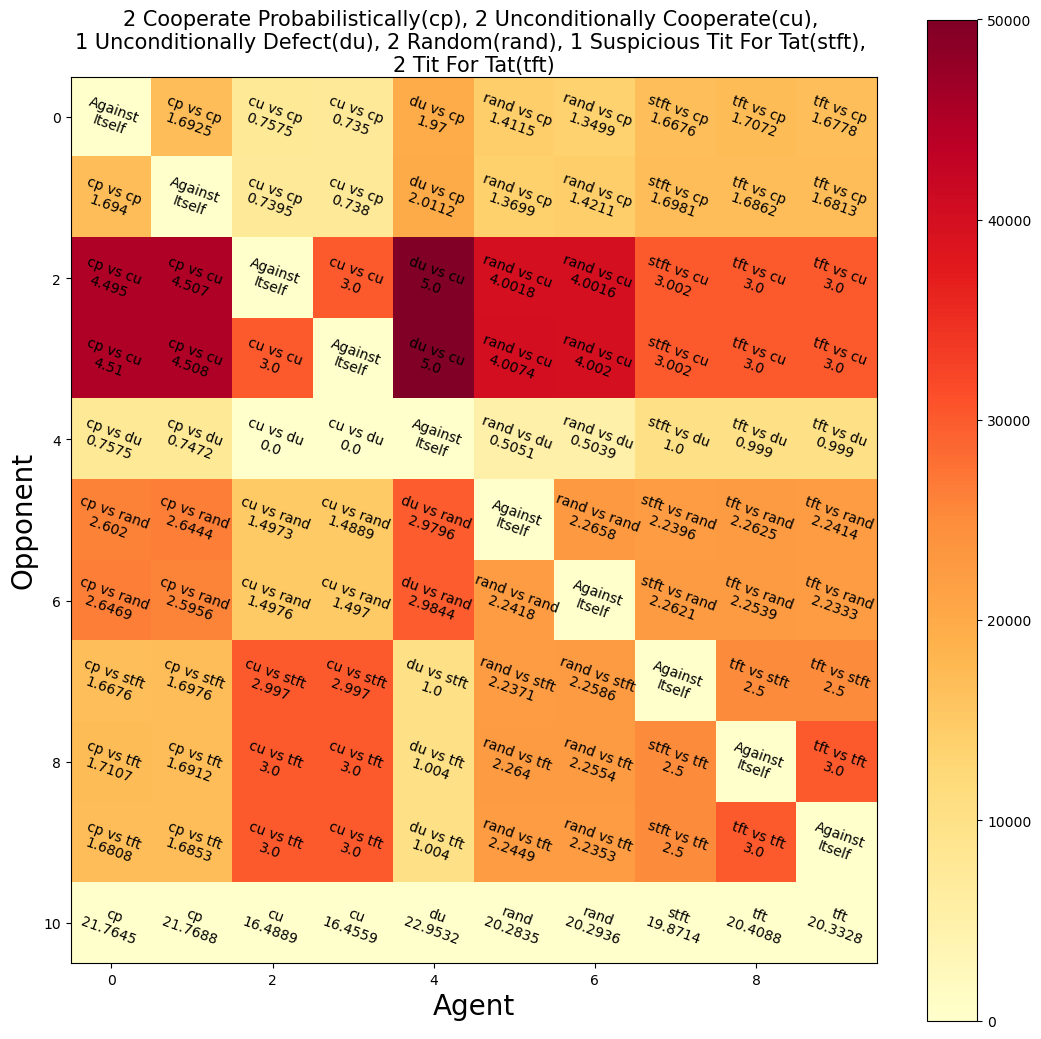

In [6]:
arb = Arbiter(1000)
agb = AgentBuilder()
agentStr, filename = agb.rand(10)
print(agentStr)
agents = arb.playTournament('cp cp cu cu du rand rand stft tft tft', 10, filename, text=True)

Agent du is index 0
Agent du is index 1
Agent du is index 2
Agent du is index 3
Agent du is index 4
Agent tft is index 5
Agent tft is index 6
Agent tft is index 7
Agent tft is index 8
Agent cu is index 9
Agent cu is index 10
Agent cu is index 11
3 Unconditionally Cooperate(cu), 5 Unconditionally Defect(du), 
4 Tit For Tat(tft), 


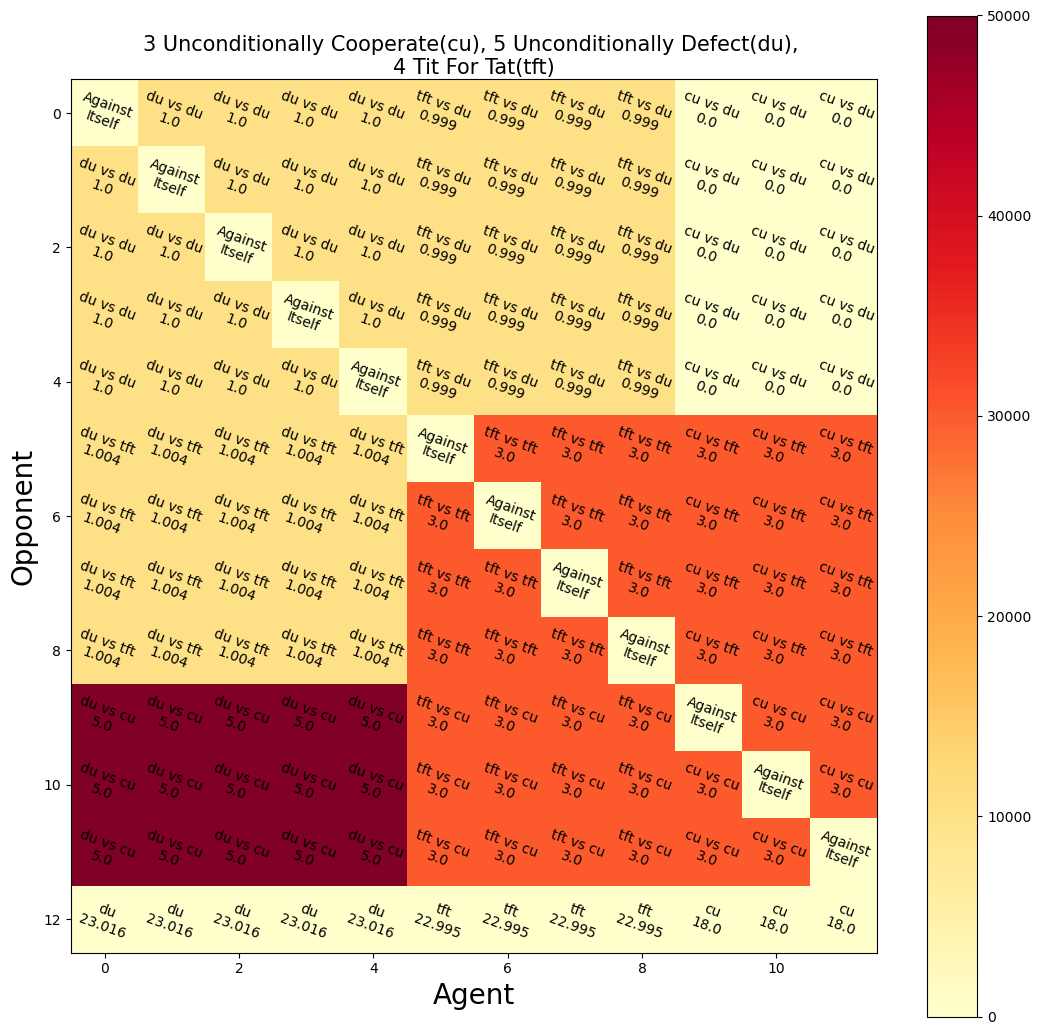

In [7]:
arb = Arbiter(1000)
agb = AgentBuilder()
agentStr, filename = agb.xOfEach(('du', 5), ('tft', 4), ('cu', 3))
agents = arb.playTournament(agentStr, 10, filename, text=True)

## Future
5 generally cooperative, 5 generally uncooperative and then round robin
make function to play round robin with an array of agents
3tft and 3DUs - good sanity check! 3 tft should win. Du wont make much off of other DUs and only a little against tft. Tft will make lots off the other tft

Big question: What strategies thrive in what conditions? In what conditions will TFT show its value? Are there conditions where CU is better? What agents do best where?

# Spatial!

### Plan:
Have agents placed on a board, interacting with each other probabilistically based on distance. 

In [ ]:
class SpatialArbiter:
    def __init__(self, size, agents, positions):
        self.size = size
        self.agents=agents
        self.positions = positions
        self.initializeGrid()

    def initializeGrid(self):
        grid = np.zeros((self.size, self.size))
        for agent, position in zip(self.agents, self.positions):
            grid[position[0], position[1]] = agent
        self.grid = grid

    def showGrid(self):
        plt.imshow(self.grid)

In [ ]:
sparb = SpatialArbiter(10, [1,2,3,4,5], [[1,1],[2,2],[3,3],[4,4],[5,5]])
sparb.showGrid()

In [ ]:
class LineArbiter:
    def __init__(self, agents):
        self.agents = agents
        self.map = list(agents)

    def showLine(self):
        plt.imshow(np.array([i for i in range(len(self.map))]).reshape(1, -1), cmap='viridis')

In [7]:
agents = [Du(), Du(), Du(), Du(), TFT(), TFT(), TFT(), Cu()]
linearb = LineArbiter(agents)
linearb.showLine()

NameError: name 'LineArbiter' is not defined

# Barnes Hut Spatial Tree - My implementation

In [2]:
class QuadNode:
    def __init__(self, points, dims, center): #dims: (xMin, xMax, yMin, yMax)
        self.children = [None, None, None, None] #ne, nw, sw, se
        self.contained = points
        self.top = dims[3]
        self.bottom = dims[2]
        self.left = dims[0]
        self.right = dims[1]
        self.center = center #x,y

    def partition(self):
        boxes = [[[],[]],[[],[]],[[],[]],[[],[]]]
        yav = np.sum(self.contained[1])/len(self.contained[1])
        xav = np.sum(self.contained[0])/len(self.contained[0])
        center = (xav, yav)
        for x, y in zip(self.contained[0], self.contained[1]):
            if x > center[0]:
                if y > center[1]:
                    #print('adding to 0')
                    boxes[0][0].append(x)
                    boxes[0][1].append(y)
                    continue
                #print('adding to 3')
                boxes[3][0].append(x)
                boxes[3][1].append(y)
                continue
            if y > center[1]:
                #print('adding to 1')
                boxes[1][0].append(x)
                boxes[1][1].append(y)
                continue
            #print('adding to 2')
            boxes[2][0].append(x)
            boxes[2][1].append(y)

        q0dims = (center[0], self.right, center[1], self.top)
        q0c = ((q0dims[0]+q0dims[1])/2,(q0dims[2]+q0dims[3])/2)
        q1dims = (self.left, center[0], center[1], self.top)
        q1c = ((q1dims[0]+q1dims[1])/2,(q1dims[2]+q1dims[3])/2)
        q2dims = (self.left, center[0], self.bottom, center[1])
        q2c = ((q2dims[0]+q2dims[1])/2,(q2dims[2]+q2dims[3])/2)
        q3dims = (center[0], self.right, self.bottom, center[1])
        q3c = ((q3dims[0]+q3dims[1])/2,(q3dims[2]+q3dims[3])/2)
        quad0 = QuadNode(boxes[0], q0dims, q0c)
        quad1 = QuadNode(boxes[1], q1dims, q1c)
        quad2 = QuadNode(boxes[2], q2dims, q2c)
        quad3 = QuadNode(boxes[3], q3dims, q3c)
        self.children = [quad0, quad1, quad2, quad3]

        for child in self.children:
            if len(child.contained[0]) > 1:
                self.contained=[[],[]]
                child.partition()
            else:
                #print(f"children: {len(child.contained)}")
                pass

    def display(self, lw):
        plt.hlines(self.top, self.left, self.right, lw=lw)
        plt.hlines(self.bottom, self.left, self.right, lw=lw)
        plt.vlines(self.left, self.bottom, self.top, lw=lw)
        plt.vlines(self.right, self.bottom, self.top, lw=lw)
        for child in self.children:
            if child != None:
                child.display(lw)

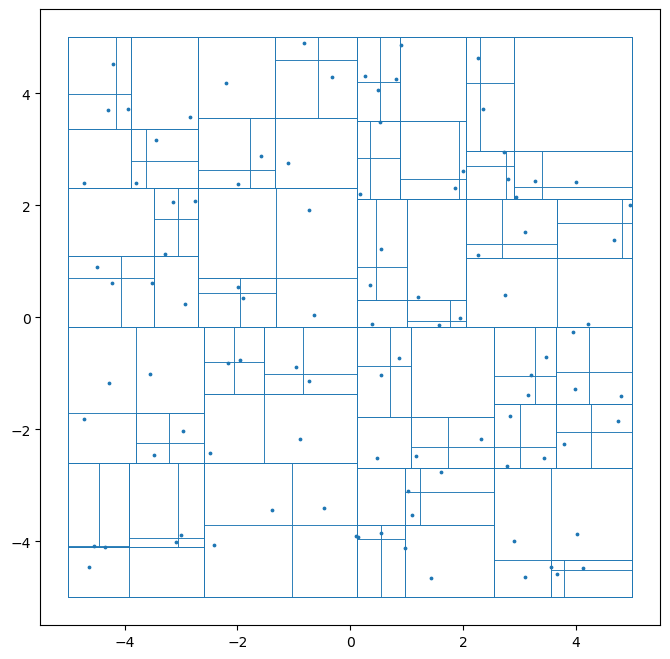

In [3]:
n = 100
x = (random.rand(n) * 10)-(np.ones(n)*5)
y = (random.rand(n) * 10)-(np.ones(n)*5)

quad = QuadNode([x, y], (-5, 5, -5, 5), (0,0))
boxes = quad.partition()

def random_color():
    return (random.random(), random.random(), random.random())

plt.figure(figsize=(8,8))
colors = [random_color() for _ in range(4)]

plt.scatter(x, y, s=3)

quad.display(0.5)

In [69]:
class NetworkArbiter:
    def __init__(self, N, iters):
        self.Nplayers = N
        self.rounds = iters
        self.constructTable()

    def constructTable(self):
        N = self.Nplayers
        possibilities = [Du, Cu, Rand, Cp, TFT, STFT]     
        agents = random.choice(possibilities, size=N, replace=True)
        for idx, agent in enumerate(agents): agents[idx] = agent(short=True)
        self.agents = agents
        adjMat = (np.ones((N,N)) - np.eye(N)) / (N-1)
        for n in range(self.Nplayers):
            randomVec = random.rand(self.Nplayers - 1)
            probVec = randomVec / np.sum(randomVec)
            adjMat[0:n,n] = probVec[:n]
            adjMat[n+1:,n] = probVec[n:]
        self.adjMat = adjMat

    def generateRound(self):
        playersLeft = set(range(self.Nplayers))
        playersSeen = set()
        games = []
        adjMat = self.adjMat
        while len(playersLeft) > 1:
            player = random.choice(list(playersLeft))
            playersLeft.remove(player)
            playersSeen.add(player)
        
            weights = np.delete(adjMat[:,player], list(playersSeen))
            weights /= np.sum(weights)
        
            opponent = random.choice(list(playersLeft), p=weights)
            playersLeft.remove(opponent)
            playersSeen.add(opponent)
            games.append(np.array([player, opponent]))
        return games
        
    def playTournament(self.agents)
        for _ in range(N):
            games = self.generateRound()
            for game in games:
                a1 = game[0]
                a2 = game[1]
                print(f'Game: {a1}, {a2}')
            print()
        #for n in range(N):
        #    games = self.selectRound()
        #    for game in games:
        #        players[game[0]].append(game[1])
        #        players[game[1]].append(game[0])
        #for player, opponents in players.items():
        #    unique, counts = np.unique(opponents, return_counts = True)
        #    games = np.sum(counts)
        #    countProp = counts/games
        #    print(f'Player: {player}, Opponents: {list(zip(unique, countProp))}, sum = {games}')

    def playOneMatchup(self, matchupLength, a1idx, a2idx):
        a1 = self.agents[a1idx]
        a2 = self.agents[a2idx]
        for _ in range(matchupLength):
            for roundNum in range(self.rounds):
                a1past = []
                a2past = []
                a1move = a1.rule(a2past, roundNum)
                a2move = a2.rule(a1past, roundNum)
                

In [70]:
netarb = NetworkArbiter(6, 100)

In [71]:
netarb.playNRounds(3)

[cu rand stft cu du stft]
Game: 3, 2
Game: 0, 4
Game: 5, 1

Game: 4, 2
Game: 0, 5
Game: 1, 3

Game: 3, 2
Game: 1, 5
Game: 4, 0



In [22]:
netarb.playNRounds(500)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

Player: 0, Opponents: [(1, 0.104), (2, 0.194), (3, 0.078), (4, 0.086), (5, 0.132), (6, 0.094), (7, 0.166), (8, 0.084), (9, 0.062)], sum = 500
Player: 1, Opponents: [(0, 0.104), (2, 0.126), (3, 0.12), (4, 0.102), (5, 0.1), (6, 0.17), (7, 0.09), (8, 0.12), (9, 0.068)], sum = 500
Player: 2, Opponents: [(0, 0.194), (1, 0.126), (3, 0.05), (4, 0.19), (5, 0.092), (6, 0.11), (7, 0.1), (8, 0.064), (9, 0.074)], sum = 500
Player: 3, Opponents: [(0, 0.078), (1, 0.12), (2, 0.05), (4, 0.108), (5, 0.228), (6, 0.104), (7, 0.08), (8, 0.136), (9, 0.096)], sum = 500
Player: 4, Opponents: [(0, 0.086), (1, 0.102), (2, 0.19), (3, 0.108), (5, 0.118), (6, 0.148), (7, 0.148), (8, 0.048), (9, 0.052)], sum = 500
Player: 5, Opponents: [(0, 0.132), (1, 0.1), (2, 0.092), (3, 0.228), (4, 0.118), (6, 0.032), (7, 0.054), (8, 0.106), (9, 0.138)], sum = 500
Player: 6, Opponents: [(0, 0.094), (1, 0.17), (2, 0.11), (3, 0.104), (4, 0.148), (5, 0.032), (7, 0.064), (8, 0.134), (9, 0.144)], sum = 500
Player: 7, Opponents: [(0

In [248]:
adjMat = np.ones((10,10)) - np.eye(10)
#print(adjMat)
for n in range(10):
    probVec = random.rand(9)
    probVec /= np.sum(probVec)
    adjMat[0:n,n] = probVec[:n]
    adjMat[n+1:,n] = probVec[n:]


#print(f'{adjMat}')

shortenedVec = adjMat[:,4]
print(shortenedVec, np.sum(shortenedVec))
shortenedVec = np.delete(shortenedVec, [1,2,3,4])
print(shortenedVec, np.sum(shortenedVec))
print(shortenedVec/np.sum(shortenedVec), np.sum(shortenedVec/np.sum(shortenedVec)))

[0.078 0.104 0.105 0.118 0.000 0.142 0.135 0.049 0.150 0.117] 0.9999999999999999
[0.078 0.142 0.135 0.049 0.150 0.117] 0.6727148407364841
[0.117 0.212 0.201 0.073 0.223 0.174] 1.0


In [178]:
players = set(range(10))
print(players)
seen = {1,2,3,4}
print(list(players - seen))
print(len(players-seen))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[0, 5, 6, 7, 8, 9]
6


In [215]:
N = 10
playersLeft = set(range(N))
playersSeen = set()
games = []
while len(playersLeft) > 1:
    #print(playersLeft)
    player = random.choice(list(playersLeft))
    playersLeft.remove(player)
    playersSeen.add(player)

    weights = np.delete(adjMat[:,player], list(playersSeen))
    weights /= np.sum(weights)

    opponent = random.choice(list(playersLeft), p=weights)
    playersLeft.remove(opponent)
    playersSeen.add(opponent)
    games.append(np.array([player, opponent]))
for game in games:
    print(game)

[4 8]
[7 1]
[9 2]
[6 3]
[5 0]


In [205]:
playersLeft = set(range(N))
print(playersLeft)
playersLeft.remove(4)
print(playersLeft)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 5, 6, 7, 8, 9}


In [ ]:
distMat = np.zeros(